In [152]:
# This file aimed to trined on a LSTM based on different power and threshould and
# see if it works.
from DataPrepocessing import *
from NeuralNets import *
from TrainMethod import *

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from functools import partial


In [153]:
model = SimpleLSTM()

(612, 833)


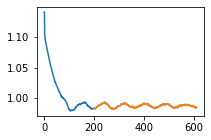

In [154]:
# read the data and only keep the stable state
plt.figure(figsize=(3,2))
raw_data_P1T1 = pd.read_csv("./data/Tracked Files/P1T1.csv")
raw_data_P1T1.fillna(0, inplace= True)
plt.plot(raw_data_P1T1.iloc[:,1])
cut_data_P1T1 = raw_data_P1T1[200:]
plt.plot(cut_data_P1T1.iloc[:,1])
print(raw_data_P1T1.shape)

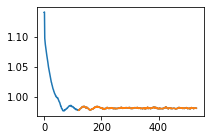

In [155]:
raw_data_P1T09 = pd.read_csv("./data/Tracked Files/P1T0.9.csv")
raw_data_P1T09.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
data = raw_data_P1T09
plt.plot(data.iloc[:,1])
cut_data_P1T09 = data[120:]
plt.plot(cut_data_P1T09.iloc[:,1])

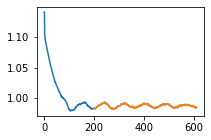

In [156]:
raw_data_P06T1 = pd.read_csv("./data/Tracked Files/P0.6T1.csv")
raw_data_P06T1.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
plt.plot(raw_data_P06T1.iloc[:,1])
cut_data_P06T1 = raw_data_P06T1[200:]
plt.plot(cut_data_P06T1.iloc[:,1])

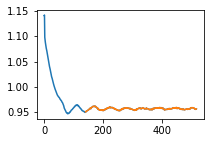

In [157]:
raw_data_P1T11 = pd.read_csv("./data/Tracked Files/P1T1.1.csv")
raw_data_P1T11.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
plt.plot(raw_data_P1T11.iloc[:,1])
cut_data_P1T11 = raw_data_P1T11[140:]
plt.plot(cut_data_P1T11.iloc[:,1])

In [188]:
# now we get all the stable data
print(len(cut_data_P1T1))
print(len(cut_data_P1T11))
print(len(cut_data_P06T1))
print(len(cut_data_P1T09))

# first, cut the data according to the sequence length
sequence_length = 10

time_cut = lambda data : data[: len(data)//sequence_length * sequence_length]

cut_data_P1T11 = time_cut(cut_data_P1T11)
cut_data_P1T1 = time_cut(cut_data_P1T1)
cut_data_P06T1 = time_cut(cut_data_P06T1)
cut_data_P1T09 = time_cut(cut_data_P1T09)

# drop the first timestamp column (OR should we keep it?)

drop_first = lambda data : data.iloc[:, 1:]

cut_data_P1T11 = drop_first(cut_data_P1T11)
cut_data_P1T1 = drop_first(cut_data_P1T1)
cut_data_P06T1 = drop_first(cut_data_P06T1)
cut_data_P1T09 = drop_first(cut_data_P1T09)




print(len(cut_data_P1T1))
print(len(cut_data_P1T11))
print(len(cut_data_P06T1))
print(len(cut_data_P1T09))

410
370
410
410
410
370
410
410


In [189]:
# this function move the keff from the first column to the last
def move_labels(df):
    # move the first column to the last column
    cols = list(df.columns)
    # df = df.iloc[:, 1:] # select all rows and columns except the first one
    df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end
    return df


In [160]:
def add_Power_and_Threshold(df, p = 1, t =1):
    df['P'] = p
    df['t'] = t

    return df

In [161]:
#cut_data_P1T11 = add_Power_and_Threshold(cut_data_P1T11,1,1.1)
#cut_data_P1T1 = add_Power_and_Threshold(cut_data_P1T1,1,1)
#cut_data_P06T1 = add_Power_and_Threshold(cut_data_P06T1,0.6,1)
#cut_data_P1T09 = add_Power_and_Threshold(cut_data_P1T09,1,0.9)

In [162]:
# question: how to deal with non-fule pebbles?
# question: how to deal with NAN values i.e. different sample number each time stamp

#all_data = pd.concat([cut_data_P1T1, cut_data_P1T11, cut_data_P06T1, cut_data_P1T09], ignore_index= True)
#all_data = cut_data_P1T11
#all_data.fillna(0, inplace= True)
#all_data = move_labels(all_data)
#print(all_data.shape)

In [230]:
# do the data preprossing
def data_generation(data):
    all_data = data
    all_data.fillna(0, inplace= True)
    all_data = move_labels(all_data)
    data = all_data.to_numpy()
    data = generate_histogram(data)
    data = standarlize(data)
    training_data = ReactorData(data,10,0,0.75)
    testing_data = ReactorData(data,10,0.75,1)
    return [training_data, testing_data]
    


In [191]:
# define neural nets

def model_train(training_data):
    
    input_dim = training_data[0][0].shape[1]



# print(output_dim)

# some adjustable hyper-parameters
    nets_hyper_parameters = {
    'input_dim' : input_dim,
    'output_dim' : 1,
    'hidden_dim' : 64,
    'lstm_nums_layer' : 2,
    'dropout' : 0.2 
    }


    model = SimpleLSTM(**nets_hyper_parameters)
    
    optimizer_parameters = {
    'params':model.parameters(),
    'lr' : 0.01,
    'weight_decay' : 0.01
    }
    
    train_parameters = {
    'model' : model,
    'training_data' : training_data,
    'epoch_num': 200,
    'batch_size':16,
    'optimizer' : optim.Adam(**optimizer_parameters),
    'loss_fn' : nn.MSELoss(),
    'print_out_frequency': 20

    }


    model, _ = train(** train_parameters)
    return model

In [239]:
P1T11_data = data_generation(cut_data_P1T11)
model_P1T11 = model_train(P1T11_data[0])

P1T1_data = data_generation(cut_data_P1T1)
model_P1T1 = model_train(P1T1_data[0])

P06T1_data = data_generation(cut_data_P06T1)
model_P06T1 = model_train(P06T1_data[0])

P1T09_data = data_generation(cut_data_P1T09)
model_P1T09 = model_train(P1T09_data[0])

/var/folders/8y/0jc3hfkn249gd1k0_nhq84_80000gn/T/ipykernel_35703/3494102704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end


The loss is 0.9874720487784119 in epoch 0
The loss is 0.025791371535194563 in epoch 20
The loss is 0.026768427889925943 in epoch 40
The loss is 0.01542512203489204 in epoch 60
The loss is 0.018555112405298065 in epoch 80
The loss is 0.017099039805619446 in epoch 100
The loss is 0.018878759956617898 in epoch 120
The loss is 0.016713822494242324 in epoch 140
The loss is 0.02658984433654377 in epoch 160
The loss is 0.020744887753150303 in epoch 180
Training is finished, the final loss is 0.017061010400630225
The loss is 1.0576665524156064 in epoch 0


/var/folders/8y/0jc3hfkn249gd1k0_nhq84_80000gn/T/ipykernel_35703/3494102704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end


The loss is 0.0314252023470486 in epoch 20
The loss is 0.018978610086374997 in epoch 40
The loss is 0.01946628708574135 in epoch 60
The loss is 0.018573368023048542 in epoch 80
The loss is 0.03108637439728656 in epoch 100
The loss is 0.027278923907618966 in epoch 120
The loss is 0.02102543867326258 in epoch 140
The loss is 0.020810757024944646 in epoch 160
The loss is 0.015619043461868912 in epoch 180
Training is finished, the final loss is 0.02183134804726803
The loss is 0.9243451442996979 in epoch 0


/var/folders/8y/0jc3hfkn249gd1k0_nhq84_80000gn/T/ipykernel_35703/3494102704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end


The loss is 0.029372568521330165 in epoch 20
The loss is 0.01784166281292968 in epoch 40
The loss is 0.017439617099383613 in epoch 60
The loss is 0.01643505818517205 in epoch 80
The loss is 0.02025124725740148 in epoch 100
The loss is 0.016334643091028545 in epoch 120
The loss is 0.019074825280078873 in epoch 140
The loss is 0.017213533605180614 in epoch 160
The loss is 0.016174846717809933 in epoch 180
Training is finished, the final loss is 0.014878115496439482
The loss is 0.9953203231273083 in epoch 0


/var/folders/8y/0jc3hfkn249gd1k0_nhq84_80000gn/T/ipykernel_35703/3494102704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end


The loss is 0.03980626539258213 in epoch 20
The loss is 0.02319437969541242 in epoch 40
The loss is 0.025193268113845615 in epoch 60
The loss is 0.02120521714970396 in epoch 80
The loss is 0.0225289627796267 in epoch 100
The loss is 0.024486546447412785 in epoch 120
The loss is 0.02725704447965483 in epoch 140
The loss is 0.027216197459726477 in epoch 160
The loss is 0.024682525863309306 in epoch 180
Training is finished, the final loss is 0.026994979999052184


In [240]:
# visualize the training output
def show(data, model):
    import matplotlib.pyplot as plt


    X = (torch.tensor(data.unshaped_data)).double()
    y = (torch.tensor(data.unshaped_labels)).double()


    plt.figure()
    plt.plot(y, label = "Real")     
    plt.plot(model(X).detach().numpy(), label = "Predict")
    plt.legend()


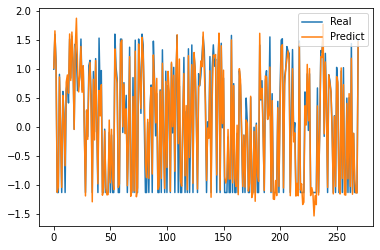

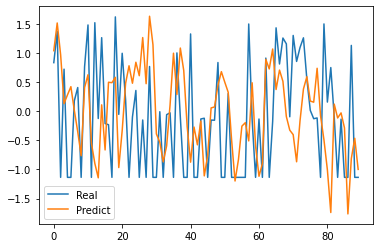

In [241]:
show(P1T11_data[0], model_P1T11)
show(P1T11_data[1], model_P1T11)

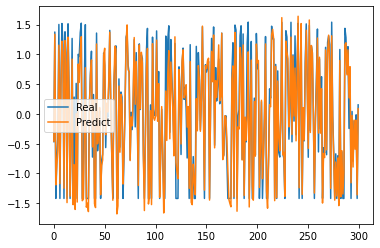

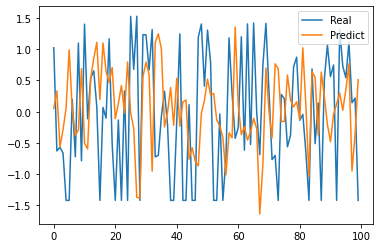

In [242]:
show(P1T1_data[0], model_P1T1)
show(P1T1_data[1], model_P1T1)

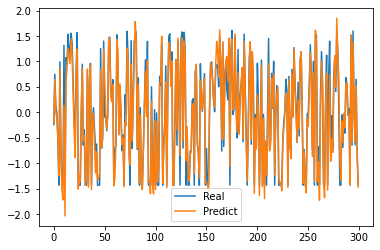

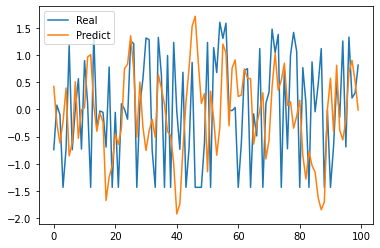

In [243]:
show(P06T1_data[0], model_P06T1)
show(P06T1_data[1], model_P06T1)

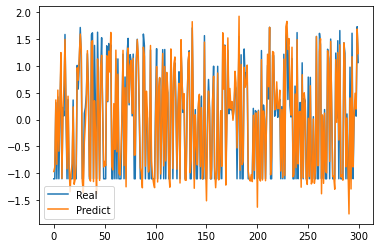

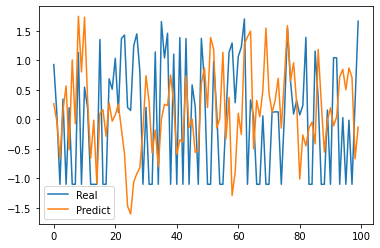

In [244]:
show(P1T09_data[0], model_P1T09)
show(P1T09_data[1], model_P1T09)

In [214]:
# view all data together (Get this to work later!!!)
import matplotlib.pyplot as plt

X = (torch.tensor(data[:,:-1])).double()
y = (torch.tensor(data[:,-1:])).double()


plt.figure()
plt.plot(y, label = "Real")     
plt.plot(model(X).detach().numpy(), label = "Predict")
plt.legend()

InvalidIndexError: (slice(None, None, None), slice(None, -1, None))